In [2]:
%matplotlib qt5

import pandas as pd
from IPython.display import display
import matplotlib
matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import seaborn as sns
import functools
from typing import Tuple

np.random.seed(13)

In [3]:
class Metrics:
    @staticmethod
    def k_fold_cross_validation(x, y, k: int, x_column_names: list = None, y_column_names: list = None, folds_to_return: int = None):
        if k <= 0 or k > len(x):
            raise ValueError(
                "k must be greater than 0 and less than the number of rows in the dataset")

        if len(x) != len(y):
            raise ValueError(
                "The number of rows in the dataset must be equal to the number of rows in the expected output")

        if folds_to_return is None: 
            folds_to_return = k

        # Shuffle the dataset
        shuffled_dataset = list(zip(x, y))
        np.random.shuffle(shuffled_dataset)
        x, y = map(
            np.array, zip(*shuffled_dataset))

        fold_len = int(len(x) / k)
        folds = []

        # Split the dataset into k folds
        # Maybe we want less folds than k
        for i in range(min(k, folds_to_return)):
            x_test = x[i *
                       fold_len: (i + 1) * fold_len]
            y_test = y[i *
                       fold_len: (i + 1) * fold_len]

            x_train = np.concatenate(
                [x[:i * fold_len],
                 x[(i + 1) * fold_len:]])

            y_train = np.concatenate(
                [y[:i * fold_len],
                 y[(i + 1) * fold_len:]])

            # If df_columns is not None, then we need to create a dataframe for both sets
            if x_column_names is not None:
                x_train = pd.DataFrame(
                    x_train, columns=x_column_names)
                x_test = pd.DataFrame(
                    x_test, columns=x_column_names)
                y_train = pd.DataFrame(
                    y_train, columns=y_column_names)
                y_test = pd.DataFrame(
                    y_test, columns=y_column_names)

            # Load the test and train sets into the folds
            folds.append({
                'x_train': x_train,
                'y_train': y_train,
                'x_test': x_test,
                'y_test': y_test,
            })

        return folds

    @staticmethod
    def k_fold_cross_validation_eval(x, y, model, k: int, x_column_names: list = None, y_column_names: list = None):
        if model is None:
            raise ValueError("Model cannot be None")

        folds = Metrics.k_fold_cross_validation(
            x, y, k=k, x_column_names=x_column_names, y_column_names=y_column_names)

        # Evaluate the model on each fold
        results = []
        errors = []
        for fold in folds:
            # Train the model
            x_train = fold['x_train']
            y_train = fold['y_train']
            model.train(pd.concat([x_train, y_train], axis=1))

            # Evaluate the model on the test set
            x_test = fold['x_test']
            y_test = fold['y_test']
            predictions = model.test(pd.concat([x_test, y_test], axis=1))
            results.append(predictions)
            errors.append(Metrics.error(predictions, y_test, uses_df=x_column_names is not None))

        return results, errors

    @staticmethod
    def error(predictions, y, uses_df=False):
        if uses_df:
            predictions = predictions.values
            y = y.values

        return functools.reduce(
            lambda x, y: 0 if x == y else 1, list(zip(predictions, y)), 0) / len(predictions)


    @staticmethod
    def get_confusion_matrix(y, y_pred, labels=None) -> pd.DataFrame:
        cf_matrix = confusion_matrix(y, y_pred, labels=labels)
        return pd.DataFrame(cf_matrix, index=labels, columns=labels)

    @staticmethod
    def plot_confusion_matrix_heatmap(cf_matrix, predicted_title="Predicted label", actual_title="Truth label", plot_title=""):
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d' )
        ax.set_xlabel(predicted_title, fontsize=15)
        ax.set_ylabel(actual_title, fontsize=15)
        plt.yticks(rotation=0)
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        plt.rcParams["figure.figsize"] = (8,6)
        plt.title(plot_title, fontsize=20)
        plt.show()

    # https://arxiv.org/pdf/2008.05756#:~:text=Accuracy%20is%20one%20of%20the,computed%20from%20the%20confusion%20matrix.&text=The%20formula%20of%20the%20Accuracy,confusion%20matrix%20at%20the%20denominator.
    @staticmethod
    def get_tp_for_class(cf_matrix, label):
        return cf_matrix[label][label]

    @staticmethod
    def get_tn_for_class(cf_matrix, label):
        # Sum all values and subtract other metrics
        return cf_matrix.to_numpy().sum() - \
            (Metrics.get_tp_for_class(cf_matrix, label) + \
            Metrics.get_fp_for_class(cf_matrix, label) + \
            Metrics.get_fn_for_class(cf_matrix, label))

    @staticmethod
    def get_fp_for_class(cf_matrix, label):
        # Sum all rows except the label row
        return sum(cf_matrix.loc[:, label]) - cf_matrix[label][label]
    
    @staticmethod
    def get_fn_for_class(cf_matrix, label):
        # Sum all columns except the label column
        return sum(cf_matrix.loc[label, :]) - cf_matrix[label][label]

    @staticmethod
    def get_accuracy_for_class(cf_matrix, label):
        # (TP + TN) / (TP + TN + FP + FN)
        numerator = Metrics.get_tp_for_class(cf_matrix, label) + Metrics.get_tn_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fp_for_class(cf_matrix, label) + Metrics.get_fn_for_class(cf_matrix, label) 
        return numerator / denominator

    @staticmethod
    def get_precision_for_class(cf_matrix, label):
        # TP / (TP + FP)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fp_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_recall_for_class(cf_matrix, label):
        # TP / (TP + FN)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_f1_score_for_class(cf_matrix, label):
        # 2 * Precision * Recall / (Precision + Recall)
        precision = Metrics.get_precision_for_class(cf_matrix, label)
        recall = Metrics.get_recall_for_class(cf_matrix, label)
        return 2 * precision * recall / (precision + recall)
    
    @staticmethod
    def get_tp_rate_for_class(cf_matrix, label):
        # TP / (TP + FN)
        return Metrics.get_recall_for_class(cf_matrix, label)

    @staticmethod
    def get_fp_rate_for_class(cf_matrix, label):
        # FP / (FP + TN)
        numerator = Metrics.get_fp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_tn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_metrics_per_class(cf_matrix) -> Tuple[dict, pd.DataFrame]:
        metrics = {}
        for label in cf_matrix.columns:
            metrics[label] = {
                'accuracy': Metrics.get_accuracy_for_class(cf_matrix, label),
                'precision': Metrics.get_precision_for_class(cf_matrix, label),
                'recall': Metrics.get_recall_for_class(cf_matrix, label),
                'f1-score': Metrics.get_f1_score_for_class(cf_matrix, label),
                'tp-rate': Metrics.get_tp_rate_for_class(cf_matrix, label),
                'fp-rate': Metrics.get_fp_rate_for_class(cf_matrix, label)
            }
        
        # Build a dataframe from the metrics dictionary
        df = pd.DataFrame.from_dict(metrics, orient='index')
        return metrics, df

    @staticmethod
    def get_roc_confusion_matrix_for_class(model, x, y, label, threshold):
        y_expected = []
        y_predicted = []
        for x_sample, y_sample in zip(x, y):
            # Classify sample to True or False depending on threshold
            y_pred_class = Metrics.get_prediction_for_class_with_threshold(model, x_sample, label, threshold)

            # Get y sample class as True or False
            y_sample_class = str(y_sample == label)

            # Add to arrays
            y_expected.append(y_sample_class)
            y_predicted.append(y_pred_class)

        # Get confusion matrix
        cf_matrix = Metrics.get_confusion_matrix(y_expected, y_predicted, labels=["True", "False"])
        return cf_matrix
    
    @staticmethod
    def get_prediction_for_class_with_threshold(model, x, label, threshold):
        y_pred = model.classify(x, label=label)
        # If prediction is above threshold, return True
        return str(y_pred >= threshold)
    
    @staticmethod
    def get_tp_and_fp_rate_cf_matrix_by_class(cf_matrix, label) -> Tuple[float, float]:
        tp = Metrics.get_tp_rate_for_class(cf_matrix, label)
        fp = Metrics.get_fp_rate_for_class(cf_matrix, label)
        return tp, fp

    @staticmethod
    def get_roc_curve_for_class(model, x, y, label, thresholds: list[float]) -> Tuple[list[float], list[float]]:
        y_tp_rates = []
        x_fp_rates = []

        for threshold in thresholds:
            cf_matrix = Metrics.get_roc_confusion_matrix_for_class(model, x, y, label, threshold)
            tp, fp = Metrics.get_tp_and_fp_rate_cf_matrix_by_class(cf_matrix, "True")
            y_tp_rates.append(tp)
            x_fp_rates.append(fp)
        
        return x_fp_rates, y_tp_rates
    
    @staticmethod
    def plot_roc_curves(model, x, y, labels: list[str], thresholds: list[float]) -> list[pd.DataFrame]:
        plt.figure(figsize=(12,12))
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        roc_curves_df = []

        for label in labels:
            x_fp_rates, y_tp_rates = Metrics.get_roc_curve_for_class(model, x, y, label, thresholds)
            
            # Plot a smooth ROC curve
            auc_score = Metrics.get_roc_auc_score(x_fp_rates, y_tp_rates)
            plt.plot(x_fp_rates, y_tp_rates, label=f'{label} - AUC {auc_score}', marker='o')

            # Add to dataframe
            roc_curves_df.append(pd.DataFrame([x_fp_rates, y_tp_rates], index=['FP', 'TP'], columns=thresholds))

        # Plot ROC curve
        plt.plot([0, 1], [0, 1], 'k--')

        plt.legend(fontsize=15)
        plt.show()

        return roc_curves_df
    
    @staticmethod
    def get_roc_auc_score(x_fp_rates, y_tp_rates):
        return auc(x_fp_rates, y_tp_rates)



#### Naive Bayes Text Classifier

In [4]:
class NaiveBayesTextClassifier():
    predicted_class_column_name = 'prediccion'

    def __init__(self, classes, text_column_name, classes_column_name, tokenizer):
        self.relative_frequencies = {}  # by_class_by_value
        self.negated_relative_accum_frequencies = {}  # by_class
        self.classes_probabilities = {}
        self.classes = classes
        self.classes_column_name = classes_column_name
        self.text_column_name = text_column_name
        self.row_count_by_class = {}
        self.tokenizer = tokenizer

    def train(self, data_df):
        word_list = set()
        for c in self.classes:
            class_df = data_df[data_df[self.classes_column_name] == c]

            self.row_count_by_class[c] = len(class_df)
            self.classes_probabilities[c] = len(class_df) / len(data_df)

            values_appearances = {}
            # iterate over rows within class
            for i in range(len(class_df)):
                row = class_df.iloc[[i]]

                tokenized_text = self.tokenizer(
                    row[self.text_column_name].values[0])
                # iterate over values within row
                for token in tokenized_text:
                    word_list.add(token)
                    # initialize possible value if not present in map, otherwise increment appereances
                    if token not in values_appearances:
                        values_appearances[token] = 1
                    else:
                        values_appearances[token] += 1

            # calculate relative frequencies
            self.relative_frequencies[c] = {token: (token_count + 1) / (len(class_df) + len(
                self.classes)) for token, token_count in values_appearances.items()}
        
        # For every class, calculate the relative accumulative frequencies of the words not being in it
        for c in self.classes: 
            class_df = data_df[data_df[self.classes_column_name] == c]
            p = 1
            for word in word_list:
                if word in self.relative_frequencies[c]:
                    # If the word is in the class, just negate it
                    p *= (1 - self.relative_frequencies[c][word])
                else:
                    # If the word is not in the class, then negate the laplace smoothing
                    p *= (1 - (1 / (len(class_df) + len(self.classes))))
            
            # Store all the negated relative accumulative frequencies for the class
            self.negated_relative_accum_frequencies[c] = p
        

    def classify(self, sample, label = None):
        tokenized_sample = self.tokenizer(sample)
        classification = {}

        for c in self.classes:

            prod = self.classes_probabilities[c]
            token_likelihoods = self.relative_frequencies[c]
            laplace_constant = 1 / \
                (self.row_count_by_class[c] + len(self.classes))

            for token in tokenized_sample:
                token_relative_frequency = token_likelihoods[token] if token in token_likelihoods else laplace_constant

                # Divide by the probability of not being in the class, as below we are multiplying by it
                # so we have to cancel it out
                prod *= token_relative_frequency / (1 - token_relative_frequency)

            # Multiply by the probability of not being in the class, as every word is an attribute
            classification[c] = prod * self.negated_relative_accum_frequencies[c]

        # Divide by sum of all class probabilities to get final probability
        classification = {c: p / sum(classification.values()) for c, p in classification.items()}
        classifications = dict(sorted(classification.items(), key=lambda item: item[1], reverse=True))

        # If a specific label is given, return the probability of the label
        if label is not None:
            return classifications[label]
        return classifications

    def test(self, test_df):
        predicted_classes = []
        expected_classes= []

        for i in range(len(test_df)):
            row = test_df.iloc[[i]]
            row_class = row[self.classes_column_name].values[0]

            classification = self.classify(
                row[self.text_column_name].values[0])
            predicted_class = max(classification, key=classification.get)

            predicted_classes.append(predicted_class)
            expected_classes.append(row_class)

        # append results column to new dataframe
        results_df = test_df.copy()
        results_df[self.predicted_class_column_name] = predicted_classes
        results_df[self.classes_column_name] = expected_classes

        return results_df


#### Tokenizer

In [5]:
def tokenize(text: str):
    return text.split()


#### Naive Bayes Text classification model initialization and build dataset

In [6]:
data_df = pd.read_csv("./Noticias_argentinas.txt", header=0, sep='\t')
classes = ["Economia", "Salud", "Deportes", "Ciencia y Tecnologia"]

data_df = data_df[data_df["categoria"].isin(classes)]

nbclassifier = NaiveBayesTextClassifier(
    classes, "titular", "categoria", tokenize)

y = data_df.loc[:, ["categoria"]]
x = data_df.loc[:, ["titular"]]

#### K-fold cross-validation

In [7]:
# results, errors = Metrics.k_fold_cross_validation_eval(x.values.tolist(), y.values.tolist(
# ), model=nbclassifier, x_column_names=x.columns, y_column_names=y.columns, k=5)
# print(errors)

#### Train and test model

In [8]:
# Get train and test sets
folds = Metrics.k_fold_cross_validation(x.values.tolist(), y.values.tolist(), x_column_names=x.columns, y_column_names=y.columns, k=5, folds_to_return=1)
train = pd.concat([folds[0]['x_train'], folds[0]['y_train']], axis=1)
test = pd.concat([folds[0]['x_test'], folds[0]['y_test']], axis=1)
print(len(test))

# Train the model
nbclassifier.train(train)

# Test the model
results = nbclassifier.test(test)

# train_set = data_df.sample(frac=0.8, random_state=1)
# print("======================")
# print(train_set.index)
# test_set = data_df.drop(train_set.index)

# nbclassifier.train(train_set)
# print(nbclassifier.test(test_set))

# sample_columns = data_df.columns.drop("categoria")

# print(nbclassifier.classify("Histórico: Los Pumas derrotaron por primera vez a los All Blacks en Nueva Zelanda"))
# print(nbclassifier.classify("Maradona negó haber criticado a Messi, disparó otra vez contra Scaloni y también la ligó Solari"))
# print(nbclassifier.classify("Guzmán"))

3081


#### Build confusion matrix

In [9]:
# Get confusion matrix
# confusion_matrix = Metrics.get_confusion_matrix(
#     results[nbclassifier.classes_column_name].values.tolist(), results[nbclassifier.predicted_class_column_name].values.tolist(), labels=nbclassifier.classes)
# Metrics.plot_confusion_matrix_heatmap(confusion_matrix)
# print(confusion_matrix)

#### Get classification report from confusion matrix

In [10]:
# Get evaluation metrics by class
# evaluation_metrics, metrics_df = Metrics.get_metrics_per_class(confusion_matrix)
# print(evaluation_metrics)
# print(metrics_df)
# metrics_df.to_csv("./dump/metrics.csv")

#### Get and plot ROC curves

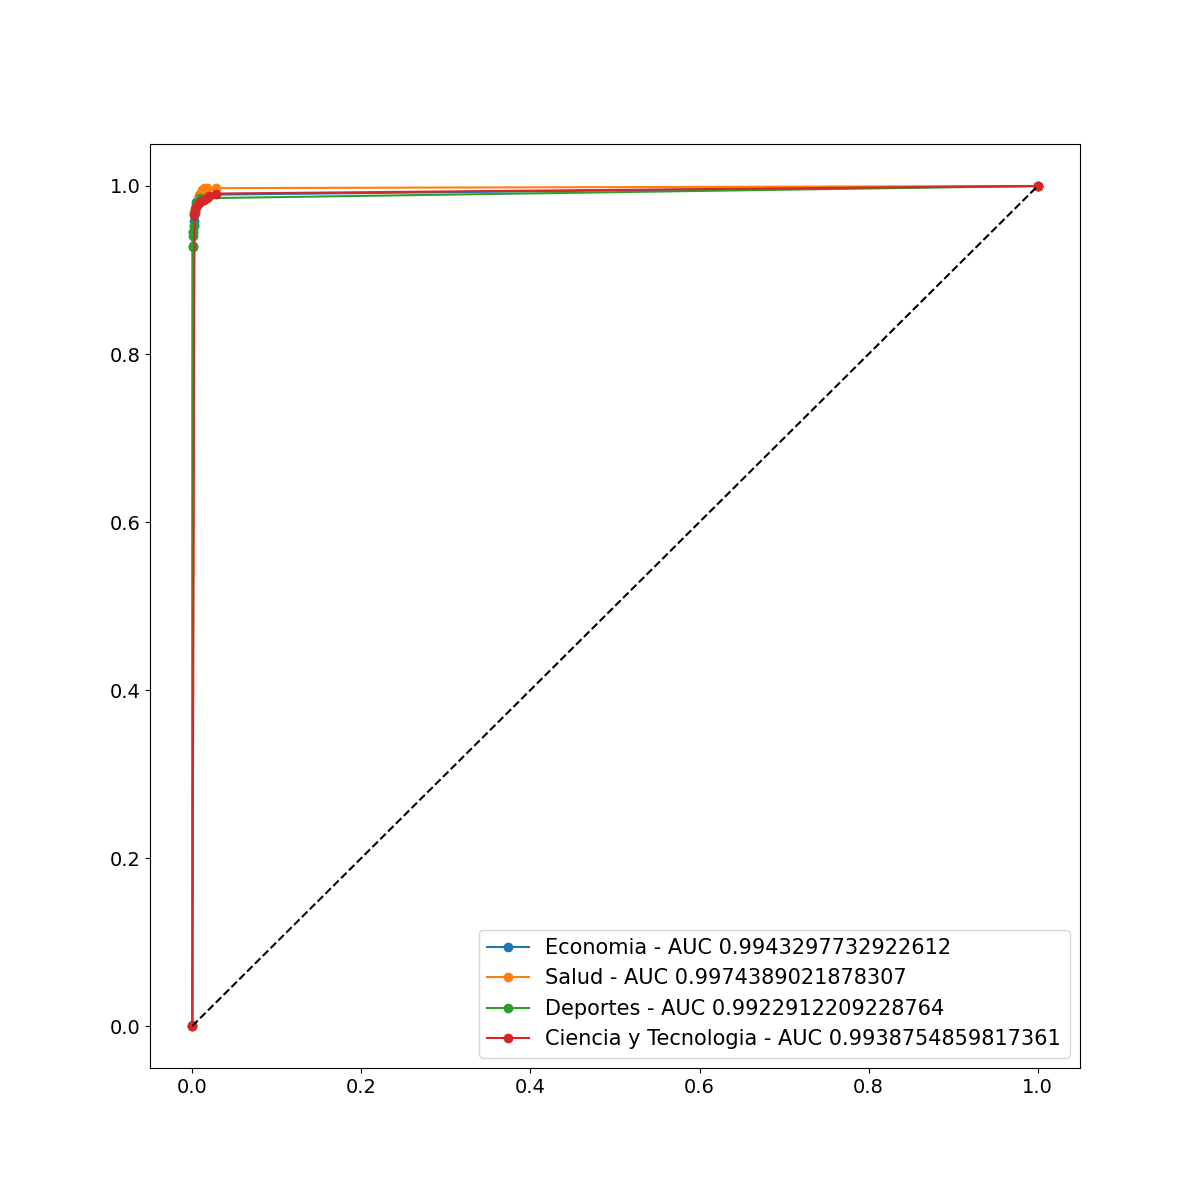

    0.0       0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
FP  1.0  0.015564  0.007782  0.004323  0.004323  0.003026  0.002594  0.001729   
TP  1.0  0.989583  0.986979  0.980469  0.975260  0.967448  0.958333  0.951823   

         0.8       0.9  1.0  
FP  0.000865  0.000432  0.0  
TP  0.945312  0.928385  0.0  
    0.0       0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
FP  1.0  0.028261  0.016957  0.013478  0.011739  0.009565  0.008261  0.007391   
TP  1.0  0.997439  0.997439  0.997439  0.994878  0.991037  0.989757  0.987196   

         0.8       0.9  1.0  
FP  0.005217  0.002174  0.0  
TP  0.979513  0.969270  0.0  
    0.0       0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
FP  1.0  0.009454  0.005587  0.004727  0.003438  0.002578  0.002149  0.000859   
TP  1.0  0.985411  0.980106  0.977454  0.969496  0.966844  0.953581  0.945623   

         0.8       0.9       1.0  
FP  0.000430  0.000430  0.000000  
TP  0.940318  0.92

In [11]:
# Get ROC curve for each class
thresholds = np.linspace(0, 1, 11, endpoint=True)
roc_curves_df = Metrics.plot_roc_curves(nbclassifier, test[nbclassifier.text_column_name].values.tolist(), test[nbclassifier.classes_column_name].values.tolist(), labels=nbclassifier.classes, thresholds=thresholds)
for roc_curve_df in roc_curves_df:
    print(roc_curve_df)
# for label in nbclassifier.classes:
#     print(f'Confusion matrix for class {label}')
#     print(Metrics.get_roc_confusion_matrix_for_class(nbclassifier, results[nbclassifier.classes_column_name].values.tolist(), results[nbclassifier.predicted_class_column_name].values.tolist(), label, 0.175))
#     # print(Metrics.get_roc_confusion_matrix_for_class(nbclassifier, ["Economia", "Economia"], ["Economia", "Economia"], label, 0.5))
